In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from numpy import savetxt
import pandas as pd
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.stats import gamma

### start with a single gamma distribution

In [ ]:
x_max = 200
DATA_POINT_NUMBER = int(1*1e7)


shape = 3.0
scale = 20.0

print(f"Will produce {DATA_POINT_NUMBER} data points for each curve")

x_range = np.linspace(start=1/np.sqrt(np.finfo(np.float32).max), stop=x_max, num=DATA_POINT_NUMBER)
#x_range = x_range.reshape(x_range.shape[0], 1)

In [ ]:
print(shape)
print(scale)
print(x_max)

In [ ]:
y_range = gamma(a=shape, scale=scale).cdf(x=x_range)

In [ ]:
plt.plot(x_range, y_range);

In [ ]:
# Let's plot the histogram
plt.hist(y_range, bins=200, log=True);

In [ ]:
shape_data = np.array([shape] * x_range.shape[0])
scale_data = np.array([scale] * x_range.shape[0])

x_data = np.array([shape_data, scale_data, x_range]).T

print(x_data.shape)

In [ ]:
np.isnan(x_data).sum() + np.isinf(x_data).sum()

In [ ]:
np.isnan(y_range).sum() + np.isinf(y_range).sum()

In [ ]:
x_pytorch = torch.tensor(x_data, dtype=torch.float32)
x_pytorch.shape

In [ ]:
np.isnan(x_pytorch).sum() + np.isinf(x_pytorch).sum()

In [ ]:
y_pytorch = torch.tensor(y_range, dtype=torch.float32).view(y_range.shape[0], -1)
y_pytorch.shape

In [ ]:
np.isnan(y_pytorch).sum() + np.isinf(y_pytorch).sum()

In [ ]:
layers = [16, 8]

layers.insert(0, 3)
print(layers)

In [ ]:
layer_list = []
for i in range(len(layers)-1):
    input_size = layers[i]
    output_size = layers[i+1]
    
    layer_list.append(torch.nn.Linear(input_size, output_size))
    layer_list.append(torch.nn.LeakyReLU())
    #layer_list.append(torch.nn.BatchNorm1d(output_size))

layer_list.append(torch.nn.Linear(output_size, 1))
layer_list.append(torch.nn.Sigmoid())
for layer in layer_list:
    print(layer)


In [ ]:
# 6 linear layers originally
net = torch.nn.Sequential(*layer_list)

print(net)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared error

In [ ]:
losses_list = []
epoch = 0

In [ ]:
%%time
EPOCH = 6


# start training
while epoch < EPOCH:
    BATCH_SIZE = 128 #np.random.randint(low=32, high=512)
    
    torch_dataset = Data.TensorDataset(x_pytorch, y_pytorch)

    loader = Data.DataLoader(
        dataset=torch_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=2,)
    
    
    epoch_loss_list = []
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        try:
            prediction = net(batch_x)     # input x and predict based on x

            loss = loss_func(prediction, batch_y)     # must be (1. nn output, 2. target)
            if ((step % 500) == 0):
                current_pct = round(100*step/(x_pytorch.shape[0]//BATCH_SIZE),2)
                print(f"Epoch: {epoch}", 
                      f"progress: {current_pct}%", 
                      f"BATCH: {BATCH_SIZE}",
                      f"Loss: {round(np.mean(epoch_loss_list), 5)}", 
                      end="\r")
                time.sleep(0.1)

            epoch_loss_list.append(np.sqrt(loss.item()))

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            
        except ValueError:
            pass
        
    losses_list.append(np.mean(epoch_loss_list))
    epoch += 1
    torch.save(net.state_dict(), "my_model")
    
print(f"Epoch: {epoch}", 
      f"progress: {current_pct}%", 
      f"BATCH: {BATCH_SIZE}",
      f"Loss: {round(np.mean(epoch_loss_list), 5)}")


In [ ]:
plt.plot(losses_list);
plt.yscale('log')

In [ ]:
plt.plot(losses_list);

In [ ]:
shapes = []
scales = []
rmse_scores = []

In [ ]:
for j in range(100):
    new_shape = 3.0
    new_scale = 20.0
    x = []
    y = []
    y_true = []

    my_gamma = gamma(a=new_shape, scale=new_scale)
    x_range = np.arange(0.0, 500.0, 0.1) 
    y_true = my_gamma.cdf(x=x_range)
    
    
    new_shape_range = [new_shape] * x_range.shape[0]
    new_scale_range = [new_scale] * x_range.shape[0]
    
    x_input = torch.tensor(np.array([new_shape_range, new_scale_range, x_range], dtype=np.float32).T)
    
    net.eval()
    y_pred = net(x_input).squeeze()
    
    
    y_pred = np.array(y_pred.detach())
    y_true = np.array(y_true)
    

    my_rmse = np.sqrt(np.nanmean((y_true - y_pred)**2))


    scales.append(new_scale)
    shapes.append(new_shape)
    rmse_scores.append(my_rmse)
    print(j, end="\r")

plt.plot(x_range,y_pred, label="Prediction")
plt.plot(x_range,y_true, label="True CDF")
plt.title(f"shape={new_shape}, scale={new_scale}, RMSE={my_rmse}")
plt.legend()
plt.show()

In [ ]:
y_pred

In [ ]:
plt.scatter(scales, shapes, c=rmse_scores)
plt.xlabel("Scale")
plt.ylabel("Shape")
print(np.nanmin(rmse_scores), "-",np.nanmax(rmse_scores))

In [27]:
shape_max = 20.0
scale_max = 20.0
x_max = 1000
DATA_POINT_NUMBER = int(5*1e7)


shape_range = np.random.random(size=100) * shape_max
scale_range1 = np.random.random(size=100) * scale_max 
scale_range2 = np.random.random(size=100) * 0.01

scale_range = np.concatenate([scale_range1,scale_range2])

data_points_per_curve = int(DATA_POINT_NUMBER/(shape_range.shape[0]*scale_range.shape[0]))
print(f"Will produce {data_points_per_curve} data points for each curve")

x_range = np.linspace(start=1/np.sqrt(np.finfo(np.float32).max), stop=x_max, num=data_points_per_curve)
#x_range = x_range.reshape(x_range.shape[0], 1)

Will produce 2500 data points for each curve


In [28]:
print(shape_max)
print(scale_max)
print(x_max)

20.0
20.0
1000


In [29]:
gamma_data_np = np.zeros(shape=(DATA_POINT_NUMBER, 5))

In [30]:
current_marker = 0
current_shape_marker = 0
current_scale_marker = 0

In [31]:
%%time
while current_marker < DATA_POINT_NUMBER:
    
    current_shape_marker = 0
    while current_shape_marker < shape_range.shape[0]:
        new_shape = shape_range[current_shape_marker]
        current_scale_marker = 0 
        
        
        while current_scale_marker < scale_range.shape[0]:
            new_scale = scale_range[current_scale_marker]
            
            
            my_gamma = gamma(a=new_shape, scale=new_scale)
            
            
            new_pdfs = my_gamma.pdf(x=x_range)
            new_ys = my_gamma.cdf(x=x_range)
            
            
            gamma_data_np[current_marker:current_marker+x_range.shape[0], 0] = new_shape
            gamma_data_np[current_marker:current_marker+x_range.shape[0], 1] = new_scale
            gamma_data_np[current_marker:current_marker+x_range.shape[0], 2] = new_pdfs
            
            gamma_data_np[current_marker:current_marker+x_range.shape[0], 3] = x_range[:]
            gamma_data_np[current_marker:current_marker+x_range.shape[0], 4] = new_ys[:]
            
            current_marker += x_range.shape[0]
            if ((current_marker % 10) == 0):
                print(f"shape: {current_shape_marker}",
                      f", scale: {current_scale_marker}",
                      f", progress: {round(100*current_marker/DATA_POINT_NUMBER,13)}%", end="\r")
                
            current_scale_marker += 1
            
        current_shape_marker += 1

CPU times: user 29.6 s, sys: 3.48 s, total: 33.1 s: 102 , progress: 88.515%
Wall time: 31.8 s


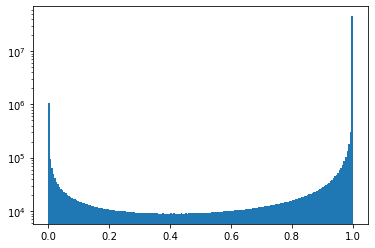

In [32]:
# Let's plot the histogram
plt.hist(gamma_data_np[:, -1], bins=200, log=True);

In [33]:
savetxt('gamma_numpy_data.csv', gamma_data_np, delimiter=',')

In [34]:
x_pytorch = torch.tensor(gamma_data_np[:current_marker, :-1], dtype=torch.float32)
x_pytorch.shape

torch.Size([50000000, 4])

In [35]:
y_pytorch = torch.tensor(gamma_data_np[:current_marker, -1], dtype=torch.float32).view(current_marker, -1)
y_pytorch.shape

torch.Size([50000000, 1])

In [83]:
layers = [64, 32, 32, 32, 16]

layers.insert(0, x_pytorch.shape[1])
print(layers)

[4, 64, 32, 32, 32, 16]


In [84]:
layer_list = []
for i in range(len(layers)-1):
    input_size = layers[i]
    output_size = layers[i+1]
    
    layer_list.append(torch.nn.Linear(input_size, output_size))
    layer_list.append(torch.nn.PReLU())
    #layer_list.append(torch.nn.Dropout(p=0.1))
    #layer_list.append(torch.nn.BatchNorm1d(output_size))

    
layer_list.append(torch.nn.Linear(output_size, 2))
layer_list.append(torch.nn.Sigmoid())

layer_list.append(torch.nn.Linear(2, 1))
#layer_list.append(torch.nn.Sigmoid())
for layer in layer_list:
    print(layer)


Linear(in_features=4, out_features=64, bias=True)
PReLU(num_parameters=1)
Linear(in_features=64, out_features=32, bias=True)
PReLU(num_parameters=1)
Linear(in_features=32, out_features=32, bias=True)
PReLU(num_parameters=1)
Linear(in_features=32, out_features=32, bias=True)
PReLU(num_parameters=1)
Linear(in_features=32, out_features=16, bias=True)
PReLU(num_parameters=1)
Linear(in_features=16, out_features=2, bias=True)
Sigmoid()
Linear(in_features=2, out_features=1, bias=True)


In [85]:
# 6 linear layers originally
net = torch.nn.Sequential(*layer_list)

print(net)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): PReLU(num_parameters=1)
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): PReLU(num_parameters=1)
  (8): Linear(in_features=32, out_features=16, bias=True)
  (9): PReLU(num_parameters=1)
  (10): Linear(in_features=16, out_features=2, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=2, out_features=1, bias=True)
)


In [86]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_func = torch.nn.L1Loss()  # this is for regression mean squared error

In [89]:
losses_list = []
max_loss_list = []
epoch = 0

In [131]:
%%time
EPOCH = 60


# start training
while epoch < EPOCH:
    BATCH_SIZE = np.random.randint(low=32, high=512)
    #BATCH_SIZE = 128
    
    torch_dataset = Data.TensorDataset(x_pytorch, y_pytorch)

    loader = Data.DataLoader(
        dataset=torch_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=2,)
    
    
    epoch_loss_list = []
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        try:
            prediction = net(batch_x)     # input x and predict based on x

            loss = loss_func(prediction, batch_y)     # must be (1. nn output, 2. target)
            if ((step % 500) == 0):
                current_pct = round(100*step/(x_pytorch.shape[0]//BATCH_SIZE),2)
                print(f"Epoch: {epoch}", 
                      f"progress: {current_pct}%", 
                      f"BATCH: {BATCH_SIZE}",
                      f"Loss: {round(np.mean(epoch_loss_list), 5)}", 
                      f"Max Loss: {round(np.max(epoch_loss_list), 5)}",
                      end="\r")
                time.sleep(0.1)

            #epoch_loss_list.append(np.sqrt(loss.item()))
            epoch_loss_list.append(loss.item())

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            
        except ValueError:
            pass
        
    losses_list.append(np.mean(epoch_loss_list))
    max_loss_list.append(np.max(epoch_loss_list))
    epoch += 1
    torch.save(net.state_dict(), "my_model")
    
print()

Epoch: 59 progress: 99.91% BATCH: 92 Loss: 0.0004 Max Loss: 0.0597845
CPU times: user 23h 16min 22s, sys: 50min 34s, total: 1d 6min 56s
Wall time: 2h 22min 59s


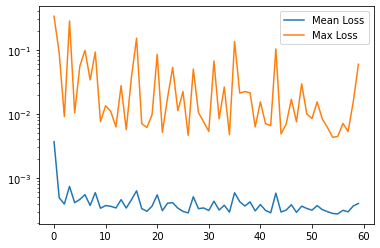

In [132]:
plt.plot(losses_list, label="Mean Loss")
plt.plot(max_loss_list, label="Max Loss")
plt.yscale('log')
plt.legend()
plt.show()

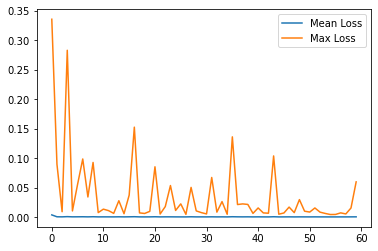

In [133]:
plt.plot(losses_list, label="Mean Loss")
plt.plot(max_loss_list, label="Max Loss")
plt.legend()
plt.show()

In [134]:
shapes = []
scales = []
rmse_scores = []

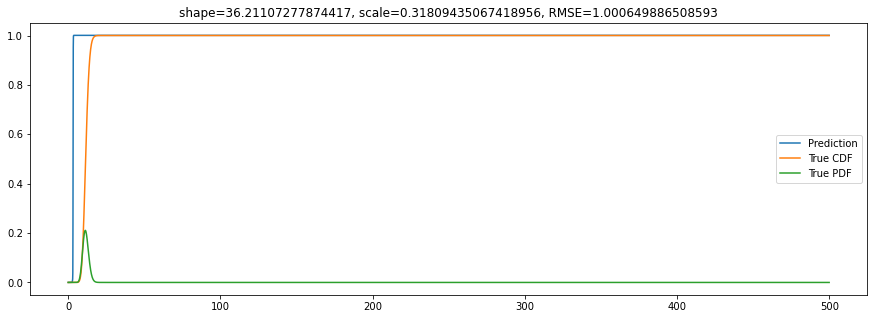

In [135]:
worst_x = None
worst_y_true = None
worst_y_pred = None
worst_rmse = 0
worst_shape, worst_scale = None, None
worst_y_pdf = None

for j in range(10000):
    new_shape = np.random.random()*40.0
    new_scale = np.random.random()*40.0
    x = []
    y = []
    y_true = []

    my_gamma = gamma(a=new_shape, scale=new_scale)    
    x_range = np.arange(0.0, 500.0, 0.1) 
    pdf_range = my_gamma.pdf(x=x_range)
    
    y_true = my_gamma.cdf(x=x_range)
    
    
    new_shape_range = [new_shape] * x_range.shape[0]
    new_scale_range = [new_scale] * x_range.shape[0]
    
    x_input = torch.tensor(np.array([new_shape_range, new_scale_range, pdf_range, x_range], dtype=np.float32).T)
    
    net.eval()
    y_pred = net(x_input).squeeze()
    
    
    y_pred = np.array(y_pred.detach())
    y_true = np.array(y_true)
    

    my_rmse = np.nanmax(np.abs((y_true - y_pred)))
    if (my_rmse > worst_rmse):
        worst_x = x_range
        worst_y_true = y_true
        worst_y_pred = y_pred
        worst_rmse = my_rmse
        worst_shape, worst_scale = new_shape, new_scale
        worst_y_pdf = pdf_range


    scales.append(new_scale)
    shapes.append(new_shape)
    rmse_scores.append(my_rmse)
    print(j, end="\r")

plt.figure(figsize=(15,5))
plt.plot(worst_x, worst_y_pred, label="Prediction")
plt.plot(worst_x, worst_y_true, label="True CDF")
plt.plot(worst_x, worst_y_pdf, label="True PDF")
plt.title(f"shape={worst_shape}, scale={worst_scale}, RMSE={worst_rmse}")
plt.legend()
plt.show()

0.0002798130742471948 - 1.000649886508593


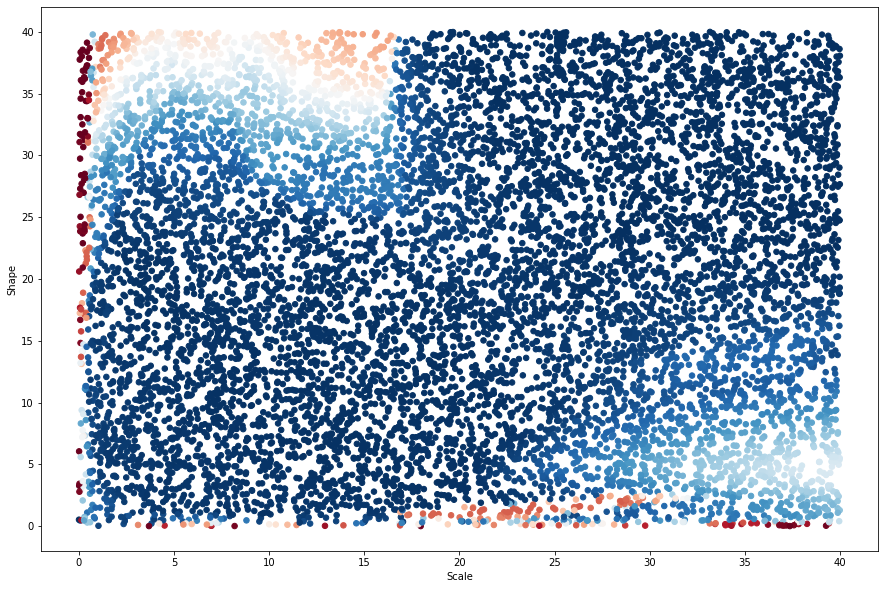

In [136]:
plt.figure(figsize=(15, 10))
plt.scatter(scales, shapes, c=-np.array(rmse_scores), s=30, cmap = 'RdBu')
plt.xlabel("Scale")
plt.ylabel("Shape")
print(np.nanmin(rmse_scores), "-",np.nanmax(rmse_scores))

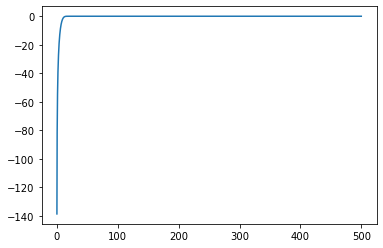

In [138]:
plt.plot(worst_x, np.log(worst_y_true), label="True CDF")